# Preparation

## Imports

In [1]:
# Data handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# Statistical analyses
import itertools
from scipy.stats import norm, truncnorm, gaussian_kde
from scipy.stats import ks_2samp, pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statistics import NormalDist
# IO
import sys

## Paths

In [2]:
# Base path for functions
base_path = "C:/repos/"
sys.path.append(base_path)

# Path to find run results
results_path = base_path + "twrds_unbiased_anns/runs/results/"

# Path to store figures
figure_path = base_path + "twrds_unbiased_anns/figures/results/grad/"

## Functions

In [3]:
# Data
from twrds_unbiased_anns.src.analysis.data import load_run_data

# Analysis - Experiment 1

## Data Loading

In [6]:
df = load_run_data(run = "grad_test", date = "25-05-2021", results_path = results_path)
df["mean_red"] = 100 - df["m_diff"]

df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

df

,Unnamed: 0,run,date,model,attr_loss_weight,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse,mean_red
0,0,grad_test,2021-05-25 10:38:21.663,GRAD,1000,mse,color,50,3,50,1,white,square,115,113.436012,over,-1.563988,1.563988,50
1,1,grad_test,2021-05-25 10:38:21.663,GRAD,1000,mse,color,50,3,50,1,white,square,127,105.765602,over,-21.234398,21.234398,50
2,2,grad_test,2021-05-25 10:38:21.663,GRAD,1000,mse,color,50,3,50,1,white,square,113,113.236061,over,0.236061,0.236061,50
3,3,grad_test,2021-05-25 10:38:21.663,GRAD,1000,mse,color,50,3,50,1,white,square,107,110.096901,over,3.096901,3.096901,50
4,4,grad_test,2021-05-25 10:38:21.663,GRAD,1000,mse,color,50,3,50,1,white,square,92,81.253639,over,-10.746361,10.746361,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,grad_test,2021-05-25 10:38:21.663,GRAD,10,mse,shape,50,3,50,5,colorful,circle,77,66.244942,under,-10.755058,10.755058,50
14996,14996,grad_test,2021-05-25 10:38:21.663,GRAD,10,mse,shape,50,3,50,5,colorful,circle,84,71.540947,under,-12.459053,12.459053,50
14997,14997,grad_test,2021-05-25 10:38:21.663,GRAD,10,mse,shape,50,3,50,5,colorful,circle,102,87.533928,under,-14.466072,14.466072,50
14998,14998,grad_test,2021-05-25 10:38:21.663,GRAD,10,mse,shape,50,3,50,5,colorful,circle,108,92.733612,under,-15.266388,15.266388,50


In [7]:
distractors = ["color", "shape"]
lambdas = [10, 100, 1000]
colors = ["lightgrey", "lightcoral"]

color
10
100.43810738220215
72.99056831970215


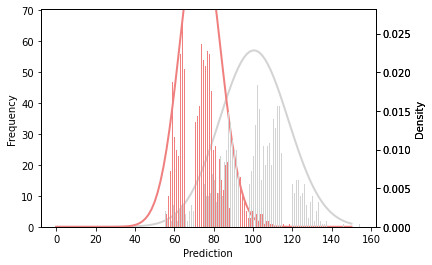

color
100
100.13778789367676
94.4932693786621


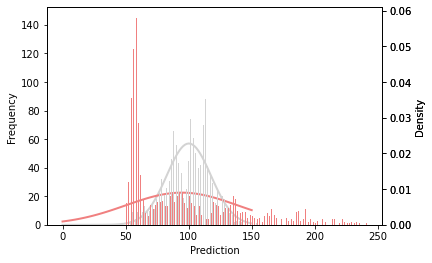

color
1000
97.00477243957519
46.4593658694759


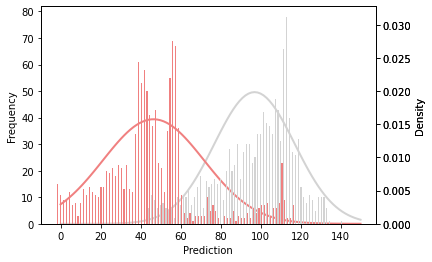

shape
10
100.83682427368164
88.90145090637208


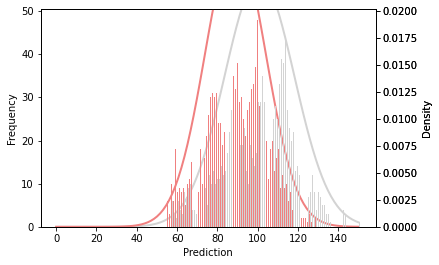

shape
100
105.917709274292
93.16696508178711


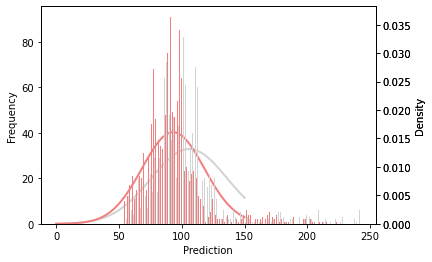

shape
1000
73.73815989376307
64.02176887512206


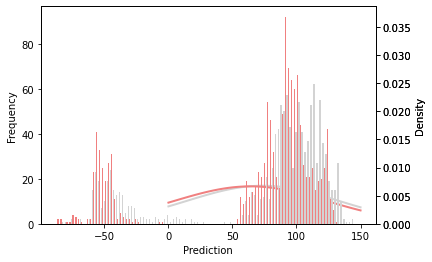

In [64]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.category == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["attr_loss_weight"] == lambda_val].copy(deep = True)
    print(distractor)
    print(lambda_val)
    print(df_filtered[df_filtered.group == "over"].prediction.mean())
    print(df_filtered[df_filtered.group == "under"].prediction.mean())    

    # Get predictions
    data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
    # Fit normal distribution
    mu_1, std_1 = norm.fit(data[0])
    mu_2, std_2 = norm.fit(data[1])

    # Create plot
    fig = plt.plot(figsize=(10,3.75))
    ax = plt.gca()      
    # Plot histogram
    ax.hist(data, color = colors, bins = 100)
    #ax.set_xlim(0,150)
    #ax.set_ylim(0,150)
    ax.set_ylabel('Frequency')  
    ax.set_xlabel('Prediction')

    # # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   

    # Plot distribution curve
    for cat_data, color in zip(data, colors):
        # Fit a normal distribution to the data
        mu, std = norm.fit(cat_data)
        # Calculate PDF
        xmin, xmax = 0, 150
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        # Plot PDF
        ax2 = ax.twinx()
        ax2.plot(x, p, color = color, linewidth = 2)
        ax2.set_ylim([0, ylim_max_2])  
        ax2.set_ylabel('Density')    
        # Fix plot display order
        ax.set_zorder(ax2.get_zorder()+1)
        ax.patch.set_visible(False)
        
    plt.show()

## Result Table

In [4]:
def get_results(data):
    avg_prediction = data.prediction.mean()
    avg_rmse = data.rmse.mean()
    return avg_prediction, avg_rmse

In [9]:
results = []

# Group data
predictors = ["category", "attr_loss_weight"]
grouped = df.groupby(predictors)

# Go through groups
for category, attr_loss_weight in grouped.groups.keys():
    
    # Get data
    data = grouped.get_group((category, attr_loss_weight))
    
    # Overall data
    avg_prediction, avg_rmse = get_results(data)
    
    # White shapes
    white_shapes = data[data.group == "over"]
    avg_prediction_w, avg_rmse_w = get_results(white_shapes)
    
    # Red shapes
    red_shapes = data[data.group == "under"]
    avg_prediction_r, avg_rmse_r = get_results(red_shapes)
    
    # Perform KS-Test
    ks_stat, ks_p = ks_2samp(white_shapes.prediction, red_shapes.prediction)
        
    # Store data
    results.append(
        {
            "category": category,
            "attr_loss_weight": attr_loss_weight,            
            "count": data.shape[0],
            "avg_prediction_w": avg_prediction_w,
            "avg_prediction_r": avg_prediction_r,
            "avg_rmse_w": avg_rmse_w,
            "avg_rmse_r": avg_rmse_r,    
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "prediction_diff": avg_prediction_w - avg_prediction_r,
            "rmse_diff": avg_rmse_w - avg_rmse_r
            
        }
    )
    
# Make dataframe of results
df_results = pd.DataFrame(results)
df_results

,category,attr_loss_weight,count,avg_prediction_w,avg_prediction_r,avg_rmse_w,avg_rmse_r,ks_stat,ks_p,prediction_diff,rmse_diff
0,color,10,2500,100.438107,72.990568,1.762931,27.441494,0.6992,3.757785e-293,27.447539,-25.678563
1,color,100,2500,100.137788,94.493269,1.386877,35.345761,0.3896,5.167648e-85,5.644519,-33.958884
2,color,1000,2500,97.004772,46.459366,6.156730,53.983730,0.7904,0.000000e+00,50.545407,-47.827000
3,shape,10,2500,100.836824,88.901451,2.071814,11.551599,0.3360,6.772428e-63,11.935373,-9.479786
4,shape,100,2500,105.917709,93.166965,9.694969,16.857938,0.3112,7.337650e-54,12.750744,-7.162969
5,shape,1000,2500,73.738160,64.021769,32.743739,41.732763,0.2040,3.621533e-23,9.716391,-8.989024


In [5]:
def get_significance_string_latex(p_val, alpha_levels = [0.05, 0.01, 0.001, 0.0001]):
  if p_val <= alpha_levels[-1]:
    return "\\tnote{ ****}"
  elif p_val <= alpha_levels[-2]:
    return "\\tnote{ ***}"
  elif p_val <= alpha_levels[-3]:
    return "\\tnote{ **}"
  elif p_val <= alpha_levels[-4]:
    return "\\tnote{ *}"
  else:
    return ""  

def convert_p_val_to_str(p):
    # Get significance indicator
    sign_str = get_significance_string_latex(p)
    # Check if p is zero
    if p == 0.0:
        return "{:.4f} {}".format(p, sign_str)
    # Check if p value would be converted to exponent notation
    if p >= 0.0001:
        return "{:.4f} {}".format(p, sign_str)
    else:
        # Convert to times notation
        p_str = str(p)
        [pre, exp] = p_str.split('e')
        exp_number = int(exp[1:])
        if exp_number > 9:
            exp_str = "{{-{}}}".format(exp_number)
        else:
            exp_str = "{{-{}\\hphantom{{0}}}}".format(exp_number)
        return "${:.2f}\\times10^{}$ {}".format(float(pre), exp_str, sign_str)

def convert_val_to_str(val):
    # Check if value would be converted to exponent notation
    if val >= 0.0001:
        return "{:.4f}".format(val)
    elif val < -0.0001:
        return "{:.4f}".format(val)
    else:
        # Convert to times notation
        val_str = str(val)
        [pre, exp] = val_str.split('e')
        exp_number = int(exp[1:])
        if exp_number > 99:
            exp_str = "{{-{}}}".format(exp_number)
        elif exp_number > 9:
            exp_str = "{{-{}\\hphantom{{0}}}}".format(exp_number)
        else:
            exp_str = "{{-{}\\hphantom{{0}}\\hphantom{{0}}}}".format(exp_number)
        return "${:.2f}\\times10^{}$".format(float(pre), exp_str)
        
header = """
% Results of 1st experiment
\\renewcommand{\\arraystretch}{1}
\\begin{table}[h!]
\\centering
\\renewcommand*\TPTnoteLabel[1]{\\parbox[b]{3em}{\\hfill#1\\,}}
\\begin{threeparttable}
\\begin{tabular*}{\\textwidth}{SSS @{\\extracolsep{\\fill}} SSSSSS[table-format=1.2e-2, table-align-text-post = false, table-space-text-post = \\tnote{ **** }] @{\\extracolsep{\\fill}}}
\\toprule
&&& \\multicolumn{2}{c}{White Shapes} & \\multicolumn{2}{c}{Red Shapes} & \\multicolumn{2}{c}{KS Test} \\\\
\\cmidrule(l{2pt}r{2pt}){4-5}
\\cmidrule(l{2pt}r{2pt}){6-7}
\\cmidrule(l{2pt}r{2pt}){8-9}
{$\\sigma$} & {$\\mathrm{\\%}_{\\mathrm{red}}$} & {$\\mu$} & {Pred.} & {RMSE} & {Pred.} & {RMSE} & {$d_{\\mathrm{n}}$} & {$p$-value} \\\\ \\midrule
"""

footer_1 = """
\\bottomrule
\\end{tabular*}
\\footnotesize
\\begin{tablenotes}
\\item[\\tnote{ ****}]$p \\leq 0.0001$ 
\\item[\\tnote{ ***}]$p \\leq 0.001$ 
\\item[\\tnote{ **}]$p \\leq 0.01$
\\item[\\tnote{ *}]$p \\leq 0.05$ 
\\end{tablenotes}
"""

footer_2 = """
\\end{threeparttable}
\\end{table}
"""

def convert_p_val_for_table(p):
    # Check if p is zero
    if p == 0.0:
        return "{:.4f}".format(p)
    # Check if p value would be converted to exponent notation
    if p >= 0.0001:
        return "{:.4f}".format(p)
    else:
        # Convert to times notation
        p_str = str(p)
        [pre, exp] = p_str.split('e')
        return "{:.2f}e{}".format(float(pre), exp)    

def print_data(data):
    for index, row in data.iterrows():
        category = row["category"]
        attr_loss_weight = row["attr_loss_weight"]        
        mean_w = round(row["avg_prediction_w"],2)        
        rmse_w = round(row["avg_rmse_w"],2)
        mean_r = round(row["avg_prediction_r"],2)
        rmse_r = round(row["avg_rmse_r"],2)
        ks_stat = round(row["ks_stat"], 2)
        if row["ks_p"] != 0.0:
            ks_p = convert_p_val_to_str(row["ks_p"])
        else:
            ks_p = "0.0000"
        ks_p_alt = convert_p_val_for_table(row["ks_p"])
        row_text = "{} & {:.0f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(category, attr_loss_weight, mean_w, rmse_w, mean_r, rmse_r, ks_stat)
        print(row_text + "& " + str(ks_p_alt) + get_significance_string_latex(row["ks_p"]) + " \\\\")
        
def print_to_latex(data):    
    # Header
    print(header)        
    # Data
    print_data(data)
    # Footer with caption and label
    caption = "\\caption{Results of experiment x.}"
    label = "\n\\label{table:results_exp_1_std_}"    
    print(footer_1+caption+label+footer_2)        

In [20]:
print_to_latex(df_results)


% Results of 1st experiment
\renewcommand{\arraystretch}{1}
\begin{table}[h!]
\centering
\renewcommand*\TPTnoteLabel[1]{\parbox[b]{3em}{\hfill#1\,}}
\begin{threeparttable}
\begin{tabular*}{\textwidth}{SSS @{\extracolsep{\fill}} SSSSSS[table-format=1.2e-2, table-align-text-post = false, table-space-text-post = \tnote{ **** }] @{\extracolsep{\fill}}}
\toprule
&&& \multicolumn{2}{c}{White Shapes} & \multicolumn{2}{c}{Red Shapes} & \multicolumn{2}{c}{KS Test} \\
\cmidrule(l{2pt}r{2pt}){4-5}
\cmidrule(l{2pt}r{2pt}){6-7}
\cmidrule(l{2pt}r{2pt}){8-9}
{$\sigma$} & {$\mathrm{\%}_{\mathrm{red}}$} & {$\mu$} & {Pred.} & {RMSE} & {Pred.} & {RMSE} & {$d_{\mathrm{n}}$} & {$p$-value} \\ \midrule

color & 10 & 100.44 & 1.76 & 72.99 & 27.44 & 0.70& 3.76e-293\tnote{ ****} \\
color & 100 & 100.14 & 1.39 & 94.49 & 35.35 & 0.39& 5.17e-85\tnote{ ****} \\
color & 1000 & 97.00 & 6.16 & 46.46 & 53.98 & 0.79& 0.0000\tnote{ ****} \\
shape & 10 & 100.84 & 2.07 & 88.90 & 11.55 & 0.34& 6.77e-63\tnote{ ****} \\
shap

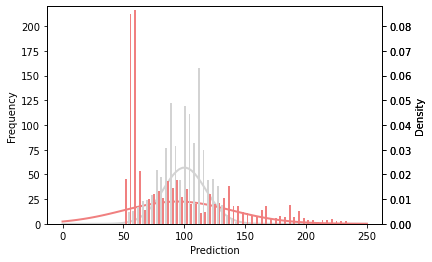

In [34]:
df_filtered = df[df.category == "color"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')



# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_color_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


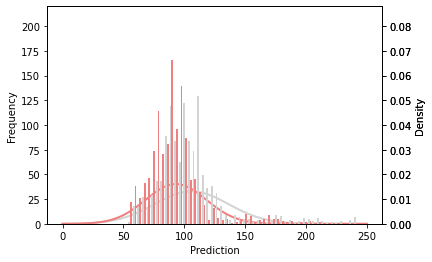

In [37]:
df_filtered = df[df.category == "shape"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')

# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_shape_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


## Loss Plots

In [4]:
import glob
import os
import pprint
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def many_logs2pandas(event_paths, lambda_splitter = "attr_loss_weight_", distractor = None):    
    all_logs = pd.DataFrame()    
    for path in event_paths:        
        # Get logs
        log = tflog2pandas(path)        
        # Check if model was from color or shape condition and add that to log df
        if distractor:
            log["distractor"] = distractor
        else:
            if "color" in path:
                log["distractor"] = "color"
            else:
                log["distractor"] = "shape"            
        # Add info about lambda to log
        log["lambda"] = path.split(lambda_splitter)[1].split("_")[0]
        # Append logs unless is first one
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)                
    return all_logs

# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_test"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir))
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,6171.333984,1.0,color,1000
1,epoch_loss,3652.429932,2.0,color,1000
2,epoch_loss,57688.804688,3.0,color,1000
3,epoch_loss,87595.406250,4.0,color,1000
4,epoch_loss,925047.125000,5.0,color,1000
...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000,46.0,shape,10
10496,epoch_attr_1_output_accuracy,1.000000,47.0,shape,10
10497,epoch_attr_1_output_accuracy,1.000000,48.0,shape,10
10498,epoch_attr_1_output_accuracy,1.000000,49.0,shape,10


In [6]:
# Params for plotting
distractors = ["color", "shape"]
lambdas = [10, 100, 1000]
target_loss = 1

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss"),
    (df["metric"] == "epoch_attr_1_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"].astype("float")
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,6171.333984,1.0,color,1000,1,0.0,1.0,6171.333984
1,epoch_loss,3652.429932,2.0,color,1000,1,0.0,1.0,3652.429932
2,epoch_loss,57688.804688,3.0,color,1000,1,0.0,1.0,57688.804688
3,epoch_loss,87595.406250,4.0,color,1000,1,0.0,1.0,87595.406250
4,epoch_loss,925047.125000,5.0,color,1000,1,0.0,1.0,925047.125000
...,...,...,...,...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000,46.0,shape,10,0,0.0,0.0,0.000000
10496,epoch_attr_1_output_accuracy,1.000000,47.0,shape,10,0,0.0,0.0,0.000000
10497,epoch_attr_1_output_accuracy,1.000000,48.0,shape,10,0,0.0,0.0,0.000000
10498,epoch_attr_1_output_accuracy,1.000000,49.0,shape,10,0,0.0,0.0,0.000000


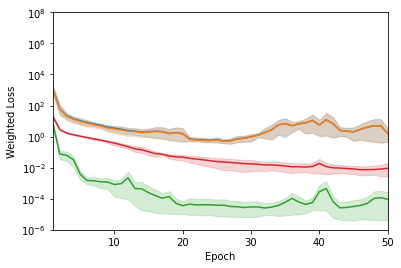

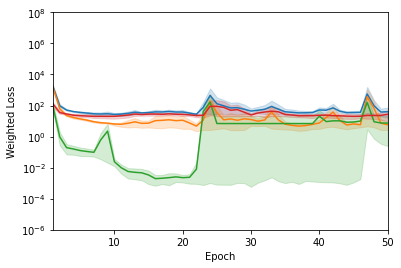

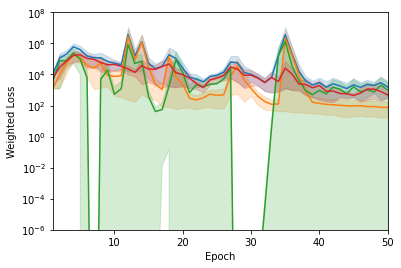

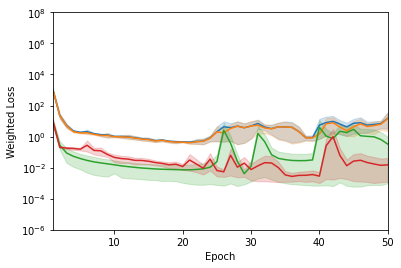

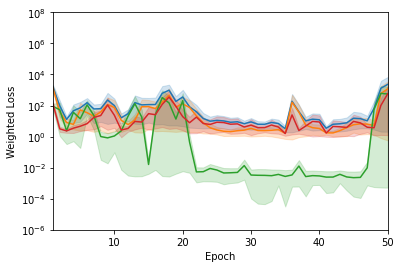

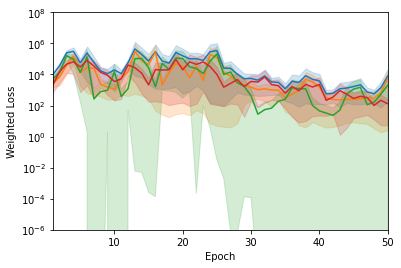

In [103]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e8])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plots

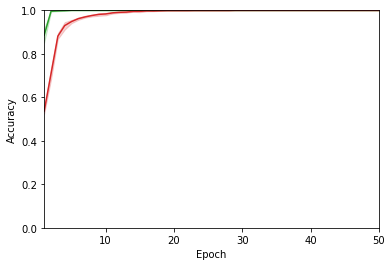

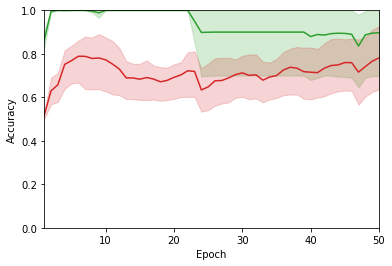

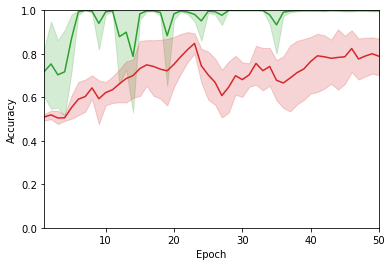

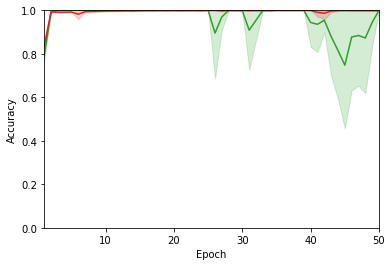

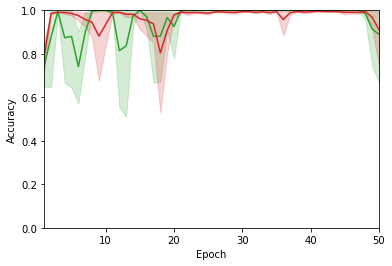

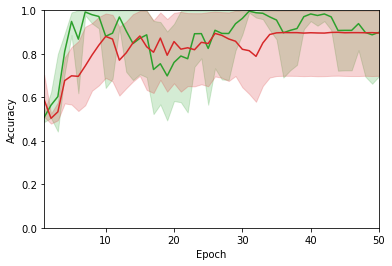

In [7]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"].astype("float") == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0, 1])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

# Experiment 2
## Data Loading

In [20]:
df = load_run_data(run = "grad_losses", date = "26-05-2021", results_path = results_path)

df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

df

,Unnamed: 0,run,date,model,attr_loss_weight,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse
0,0,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,115,0.006560,over,-114.993440,114.993440
1,1,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,127,0.006560,over,-126.993440,126.993440
2,2,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,113,0.006560,over,-112.993440,112.993440
3,3,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,107,0.006560,over,-106.993440,106.993440
4,4,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,92,0.006560,over,-91.993440,91.993440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,77,59.709942,under,-17.290058,17.290058
14996,14996,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,84,74.177185,under,-9.822815,9.822815
14997,14997,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,102,82.365868,under,-19.634132,19.634132
14998,14998,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,108,104.632957,under,-3.367043,3.367043


In [21]:
results = []

# Group data
predictors = ["category", "attr_loss_weight"]
grouped = df.groupby(predictors)

# Go through groups
for category, attr_loss_weight in grouped.groups.keys():
    
    # Get data
    data = grouped.get_group((category, attr_loss_weight))
    
    # Overall data
    avg_prediction, avg_rmse = get_results(data)
    
    # White shapes
    white_shapes = data[data.group == "over"]
    avg_prediction_w, avg_rmse_w = get_results(white_shapes)
    
    # Red shapes
    red_shapes = data[data.group == "under"]
    avg_prediction_r, avg_rmse_r = get_results(red_shapes)
    
    # Perform KS-Test
    ks_stat, ks_p = ks_2samp(white_shapes.prediction, red_shapes.prediction)
        
    # Store data
    results.append(
        {
            "category": category,
            "attr_loss_weight": attr_loss_weight,            
            "count": data.shape[0],
            "avg_prediction_w": avg_prediction_w,
            "avg_prediction_r": avg_prediction_r,
            "avg_rmse_w": avg_rmse_w,
            "avg_rmse_r": avg_rmse_r,    
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "prediction_diff": avg_prediction_w - avg_prediction_r,
            "rmse_diff": avg_rmse_w - avg_rmse_r
            
        }
    )
    
# Make dataframe of results
df_results = pd.DataFrame(results)
df_results

,category,attr_loss_weight,count,avg_prediction_w,avg_prediction_r,avg_rmse_w,avg_rmse_r,ks_stat,ks_p,prediction_diff,rmse_diff
0,color,10,2500,75.351691,43.111796,34.841754,58.334648,0.5856,6.095025e-199,32.239895,-23.492894
1,color,100,2500,137.705915,272.823060,216.131453,404.010600,0.2960,1.088662e-48,-135.117144,-187.879147
2,color,1000,2500,-1310.298074,-854.913211,1927.126809,1114.057963,0.1608,1.617510e-14,-455.384863,813.068846
3,shape,10,2500,201.024749,212.088026,125.005796,142.162622,0.1072,1.129749e-06,-11.063277,-17.156826
4,shape,100,2500,118.024858,88.807831,381.160605,370.175094,0.0688,5.375209e-03,29.217027,10.985511
5,shape,1000,2500,21.024066,-81.840673,393.495629,343.478620,0.1552,1.503941e-13,102.864740,50.017009


In [18]:
print_to_latex(df_results)


% Results of 1st experiment
\renewcommand{\arraystretch}{1}
\begin{table}[h!]
\centering
\renewcommand*\TPTnoteLabel[1]{\parbox[b]{3em}{\hfill#1\,}}
\begin{threeparttable}
\begin{tabular*}{\textwidth}{SSS @{\extracolsep{\fill}} SSSSSS[table-format=1.2e-2, table-align-text-post = false, table-space-text-post = \tnote{ **** }] @{\extracolsep{\fill}}}
\toprule
&&& \multicolumn{2}{c}{White Shapes} & \multicolumn{2}{c}{Red Shapes} & \multicolumn{2}{c}{KS Test} \\
\cmidrule(l{2pt}r{2pt}){4-5}
\cmidrule(l{2pt}r{2pt}){6-7}
\cmidrule(l{2pt}r{2pt}){8-9}
{$\sigma$} & {$\mathrm{\%}_{\mathrm{red}}$} & {$\mu$} & {Pred.} & {RMSE} & {Pred.} & {RMSE} & {$d_{\mathrm{n}}$} & {$p$-value} \\ \midrule

color & 10 & 75.35 & 34.84 & 43.11 & 58.33 & 0.59& 6.10e-199\tnote{ ****} \\
color & 100 & 137.71 & 216.13 & 272.82 & 404.01 & 0.30& 1.09e-48\tnote{ ****} \\
color & 1000 & -1310.30 & 1927.13 & -854.91 & 1114.06 & 0.16& 1.62e-14\tnote{ ****} \\
shape & 10 & 201.02 & 125.01 & 212.09 & 142.16 & 0.11& 1.13e-06\

## Loss Plots

In [10]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_losses"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir))
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,3.572866e+04,1.0,color,1000
1,epoch_loss,3.124576e+05,2.0,color,1000
2,epoch_loss,6.123622e+05,3.0,color,1000
3,epoch_loss,9.880306e+05,4.0,color,1000
4,epoch_loss,2.115204e+06,5.0,color,1000
...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000e+00,46.0,shape,10
10496,epoch_attr_1_output_accuracy,9.975000e-01,47.0,shape,10
10497,epoch_attr_1_output_accuracy,9.950000e-01,48.0,shape,10
10498,epoch_attr_1_output_accuracy,1.000000e+00,49.0,shape,10


In [11]:
# Params for plotting
distractors = ["color", "shape"]
lambdas = [10, 100, 1000]
target_loss = 0.001

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss"),
    (df["metric"] == "epoch_attr_1_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"].astype("float")
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,3.572866e+04,1.0,color,1000,1.0,0.0,1.0,3.572866e+04
1,epoch_loss,3.124576e+05,2.0,color,1000,1.0,0.0,1.0,3.124576e+05
2,epoch_loss,6.123622e+05,3.0,color,1000,1.0,0.0,1.0,6.123622e+05
3,epoch_loss,9.880306e+05,4.0,color,1000,1.0,0.0,1.0,9.880306e+05
4,epoch_loss,2.115204e+06,5.0,color,1000,1.0,0.0,1.0,2.115204e+06
...,...,...,...,...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000e+00,46.0,shape,10,0.0,0.0,0.0,0.000000e+00
10496,epoch_attr_1_output_accuracy,9.975000e-01,47.0,shape,10,0.0,0.0,0.0,0.000000e+00
10497,epoch_attr_1_output_accuracy,9.950000e-01,48.0,shape,10,0.0,0.0,0.0,0.000000e+00
10498,epoch_attr_1_output_accuracy,1.000000e+00,49.0,shape,10,0.0,0.0,0.0,0.000000e+00


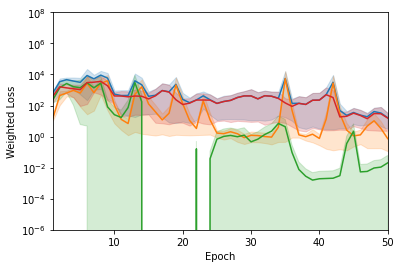

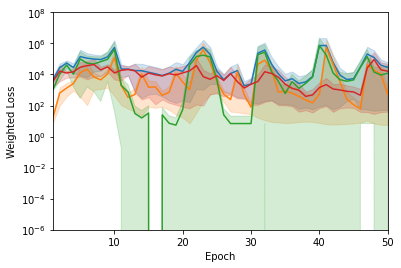

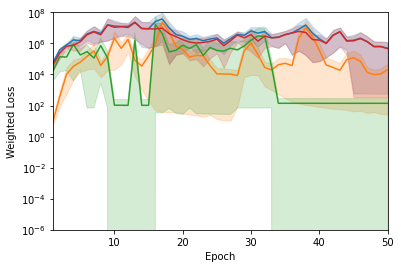

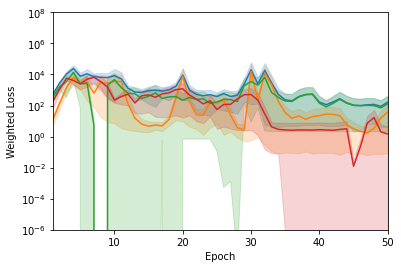

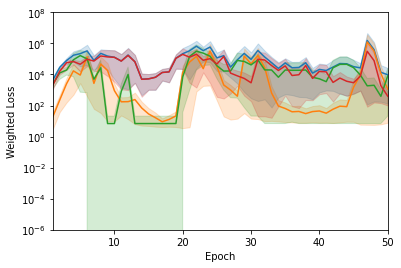

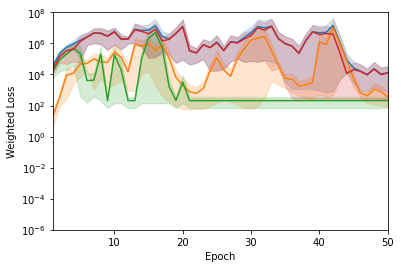

In [12]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e8])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plot

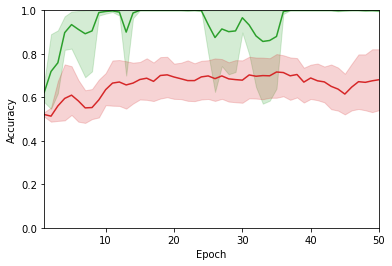

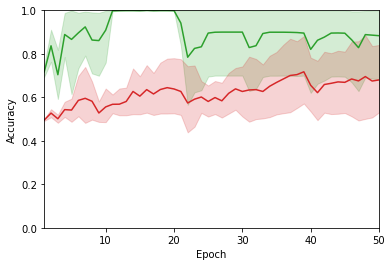

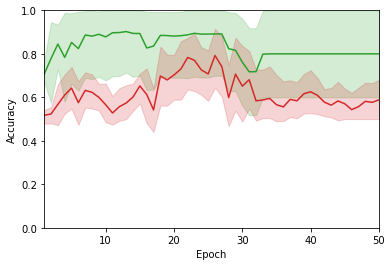

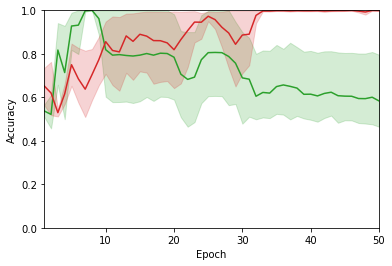

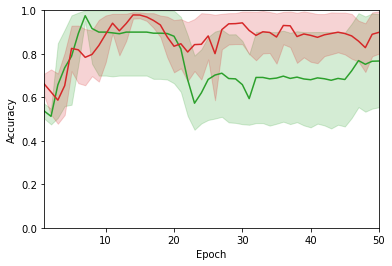

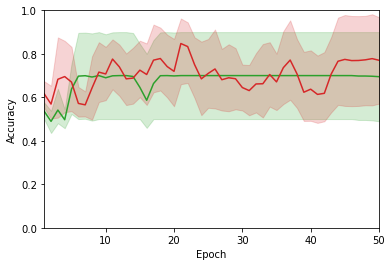

In [12]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"].astype("float") == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0, 1])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

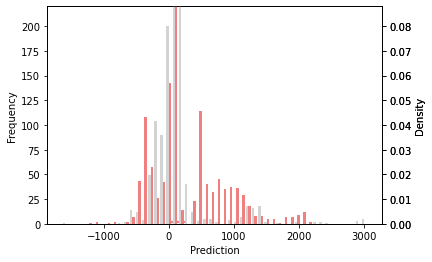

In [25]:
df_filtered = df[df.category == "color"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)
colors = ["lightgrey", "lightcoral"]

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')



# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_color_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


# Experiment 3 - Model Selection

## Loss Plots

In [7]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_fair_selection_easier"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir), "lambda_", "color")
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,1956.808228,1.0,color,0.1
1,epoch_loss,80.816071,2.0,color,0.1
2,epoch_loss,85.128738,3.0,color,0.1
3,epoch_loss,126.539909,4.0,color,0.1
4,epoch_loss,213.244568,5.0,color,0.1
...,...,...,...,...,...
5245,epoch_attr_1_output_accuracy,0.610000,46.0,color,3
5246,epoch_attr_1_output_accuracy,0.552500,47.0,color,3
5247,epoch_attr_1_output_accuracy,0.547500,48.0,color,3
5248,epoch_attr_1_output_accuracy,0.560000,49.0,color,3


In [8]:
# Params for plotting
distractors = ["color"]
lambdas = [3, 2, 1, 0.5, 0.1]
target_loss = 1

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss"),
    (df["metric"] == "epoch_attr_1_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"].astype("float")
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,1956.808228,1.0,color,0.1,1,0.0,1.0,1956.808228
1,epoch_loss,80.816071,2.0,color,0.1,1,0.0,1.0,80.816071
2,epoch_loss,85.128738,3.0,color,0.1,1,0.0,1.0,85.128738
3,epoch_loss,126.539909,4.0,color,0.1,1,0.0,1.0,126.539909
4,epoch_loss,213.244568,5.0,color,0.1,1,0.0,1.0,213.244568
...,...,...,...,...,...,...,...,...,...
5245,epoch_attr_1_output_accuracy,0.610000,46.0,color,3,0,0.0,0.0,0.000000
5246,epoch_attr_1_output_accuracy,0.552500,47.0,color,3,0,0.0,0.0,0.000000
5247,epoch_attr_1_output_accuracy,0.547500,48.0,color,3,0,0.0,0.0,0.000000
5248,epoch_attr_1_output_accuracy,0.560000,49.0,color,3,0,0.0,0.0,0.000000


In [12]:
df[df["metric"] == "epoch_attr_1_output_loss"]

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
150,epoch_attr_1_output_loss,124.548302,1.0,color,0.1,0,0.5,0.05,6.227415
151,epoch_attr_1_output_loss,407.329651,2.0,color,0.1,0,0.5,0.05,20.366483
152,epoch_attr_1_output_loss,911.972351,3.0,color,0.1,0,0.5,0.05,45.598618
153,epoch_attr_1_output_loss,1697.051392,4.0,color,0.1,0,0.5,0.05,84.852570
154,epoch_attr_1_output_loss,3205.855225,5.0,color,0.1,0,0.5,0.05,160.292761
...,...,...,...,...,...,...,...,...,...
5095,epoch_attr_1_output_loss,193570.812500,46.0,color,3,0,0.5,1.50,290356.218750
5096,epoch_attr_1_output_loss,344802.312500,47.0,color,3,0,0.5,1.50,517203.468750
5097,epoch_attr_1_output_loss,455234.906250,48.0,color,3,0,0.5,1.50,682852.359375
5098,epoch_attr_1_output_loss,394727.187500,49.0,color,3,0,0.5,1.50,592090.781250


3


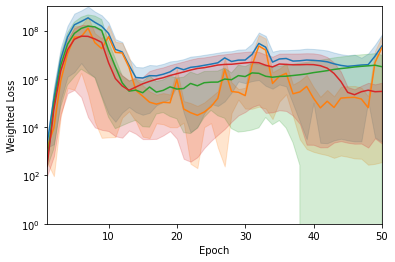

2


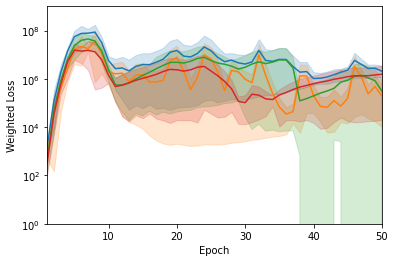

1


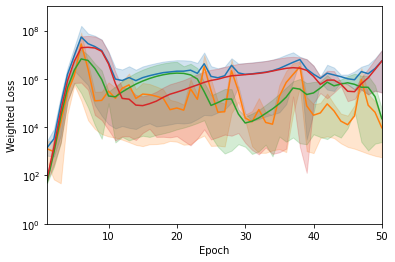

0.5


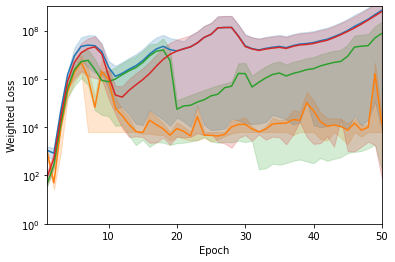

0.1


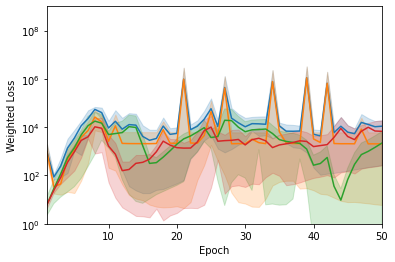

In [16]:
for lambda_val in lambdas:
    print(lambda_val)
    df_filtered = df[df["lambda"].astype("float") == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e0, 1e9])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_selection_{}.png".format(lambda_val), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plots

3


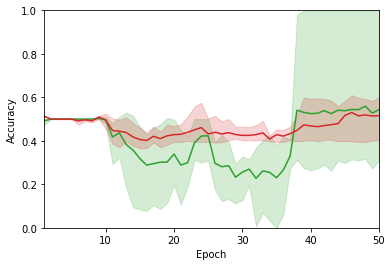

2


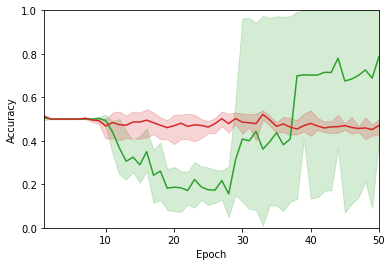

1


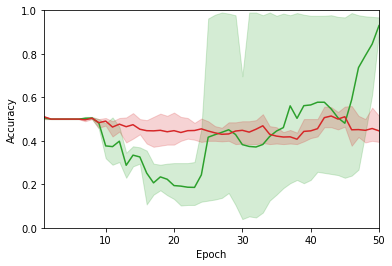

0.5


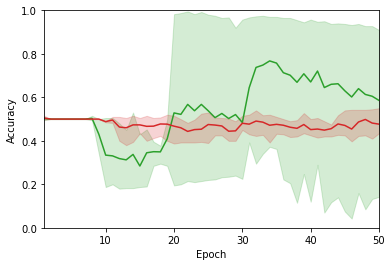

0.1


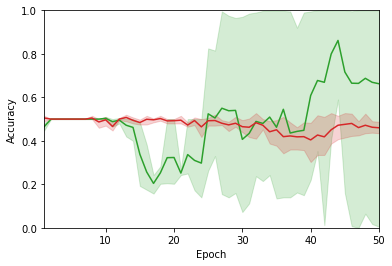

In [17]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for lambda_val in lambdas:
    print(lambda_val)
    df_filtered = df[df["lambda"].astype("float") == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0, 1])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_selection_{}.png".format(lambda_val), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

3


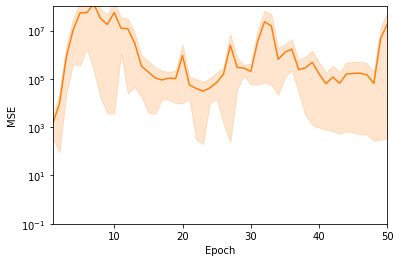

2


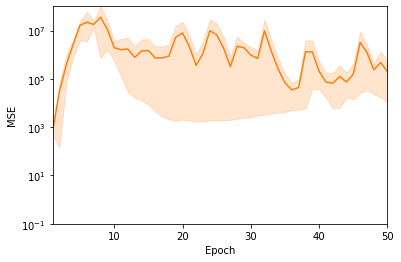

1


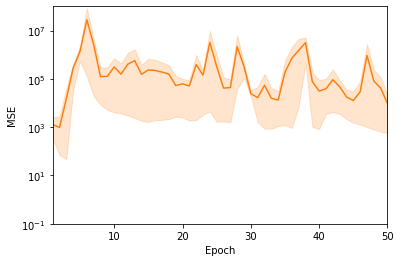

0.5


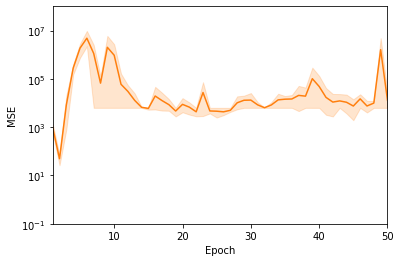

0.1


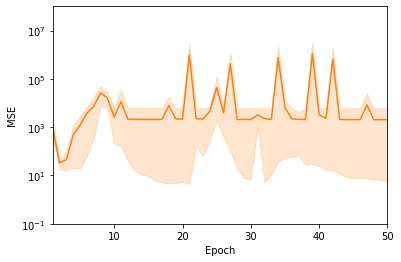

In [18]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[1:])

for lambda_val in lambdas:
    print(lambda_val)
    df_filtered = df[df["lambda"].astype("float") == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_target_output_mean_squared_error"])]
    data = data.replace("epoch_target_output_mean_squared_error", "MSE")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-1, 1e8])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/mse_plot_selection_{}.png".format(lambda_val), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)